In [1]:
import numpy as np
from scipy.sparse import csr_matrix, diags, spdiags
from scipy.sparse.linalg import spsolve, eigs, eigsh
import matplotlib.pyplot as plt

This Project aims to solve the schroudinger Equation for arbitrary potential $\texttt{pot(x, y)}$ in a confined space (infinite square well), in this case, we will consider the double slits experiment as a test case

All proceeding quantities are diminsionless, the transformation is as follows:

$\bar V = \frac{2 m_e L^2}{\hbar^2} V $

$\bar E_n = \frac{2 m_e L^2}{\hbar^2} E_n$

$\bar x = \frac{x}{L}$

$\bar t = \frac{\hbar}{2 m_e L^2} t$

I dropped the bar in the units for simplicity

In [2]:
# declare constants
hbar = 1.05457182e-34
me = 9.109e-31
nx, ny = 101, 101

In [3]:
# defining initial state
def u0(x, y): 
    # ans = 200*(x-x+1)
    # ans[(x-0.5)**2+ (y-0.5)**2>0.25]=0
    ans = 100*np.exp(-(x+0.9)*(x+0.9)/(2*0.05**2))*np.exp(-1e-20j*x)
    return ans

# define arbitrary potential
def pot(x, y):
    a = np.zeros([nx, ny])
    
    #circle:
    # a[(x-0.5)**2+ (y-0.5)**2>0.25] = -1e5
    
    #triangle:
    # a[np.logical_or(y-2*x>0, y+2*x > 2)] = 1e9
    
    # double slit:
    a[np.logical_and(x>0.48, x<0.50)] = 1e12
    a[np.logical_and(0.35>y, y>0.25)] = 0
    a[np.logical_and(0.75>y, y>0.65)] = 0
    
    # single slit:
    # a[np.logical_and(x>0.48, x<0.50)] = 1e15
    # a[np.logical_and(0.52>y, y>0.48)] = 0

    return  a

# discretize and vectorize
x, y = np.linspace(0, 1, nx), np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
U0 = u0(X, Y)
U0=U0.reshape(nx*ny)
POT = pot(X, Y).reshape(nx*ny)

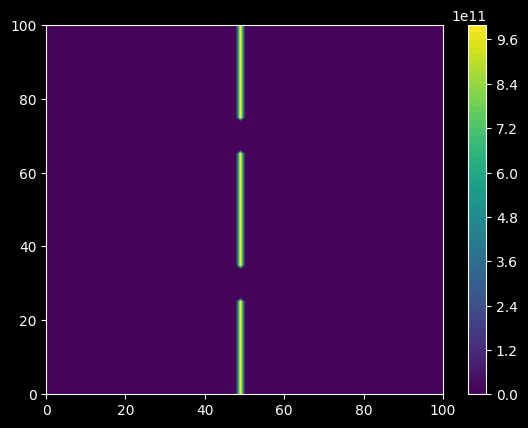

In [4]:
# verify the potential
plt.contourf(pot(X, Y), levels = 50)
plt.colorbar()

In [5]:
# define the Hamiltonian Matrix
N = nx*ny
dxdx = 9/N
main_diagonal = -(np.ones(N))*4/(dxdx)
# main_diagonal
sd_1 = np.ones(N)/dxdx
sd_1[np.arange(1, N+1, 1)%nx == 0] = 0
sd_2 = np.ones(N)/(dxdx)

diagonals = [main_diagonal, sd_1[:-1], sd_1[:-1], sd_2[nx:], sd_2[:-nx]]

laplacian = diags(diagonals, [0, -1, 1, -nx, nx], format="csr")
pot_sparse = diags([POT], [0],format="csr")
H = pot_sparse-laplacian
# laplacian.toarray()

In [7]:
sol = eigs(H, 100, which = "SM")

In [8]:
eigenvectors = sol[1].T

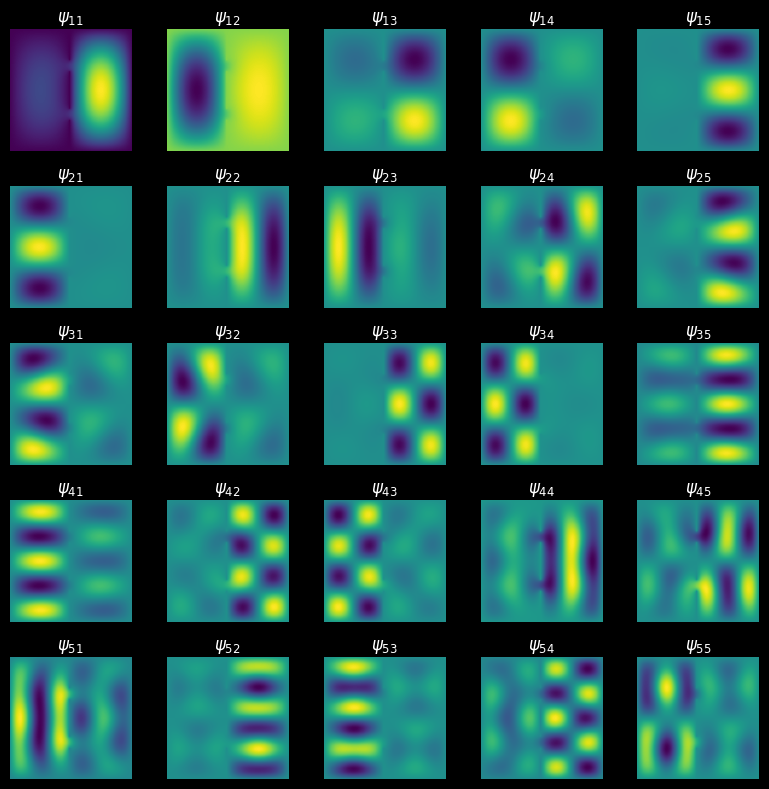

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))

for i in range(5):
    for j in range(5):
        index = 5*i + j
        eigenvector = eigenvectors[index]
        reshaped_eigenvector = sol[1].T[index].reshape((nx, ny))
        axs[i, j].imshow(np.real(reshaped_eigenvector), cmap='viridis', origin='lower')
        axs[i, j].set_title(r'$\psi_{' + str(i+1) + str(j+1) + '}$')
        axs[i, j].axis('off')

plt.tight_layout()
plt.savefig(r"Eigen_vectors.png")
plt.show()

In [10]:
# time dependant solution
def Psi(t):
    psi = 0
    for vec in range(len(sol[0])):
        psi = psi + np.dot(np.conjugate(eigenvectors[vec]), U0)*eigenvectors[vec]*np.exp(-1j*hbar/(2*me)*sol[0][vec]*t)
    return psi.reshape([nx, ny])

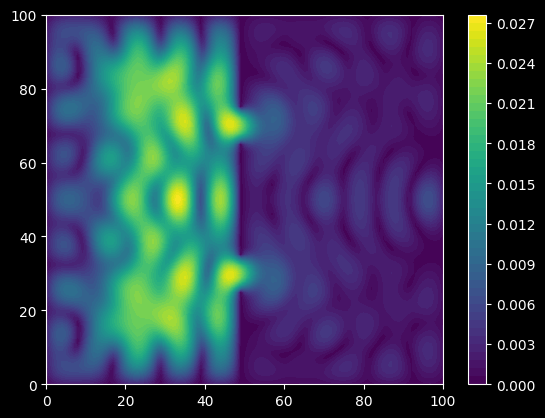

In [11]:
# plot the solution at a later time
Psi_t1000 = Psi(1000)
plt.contourf(np.absolute(Psi_t1000)/np.linalg.norm(Psi_t1000), levels = 50)
plt.colorbar()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\SS\AppData\Local\Temp\ipykernel_6728\3883356471.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$|\psi(x, t = " + str(1000) + ")|$")


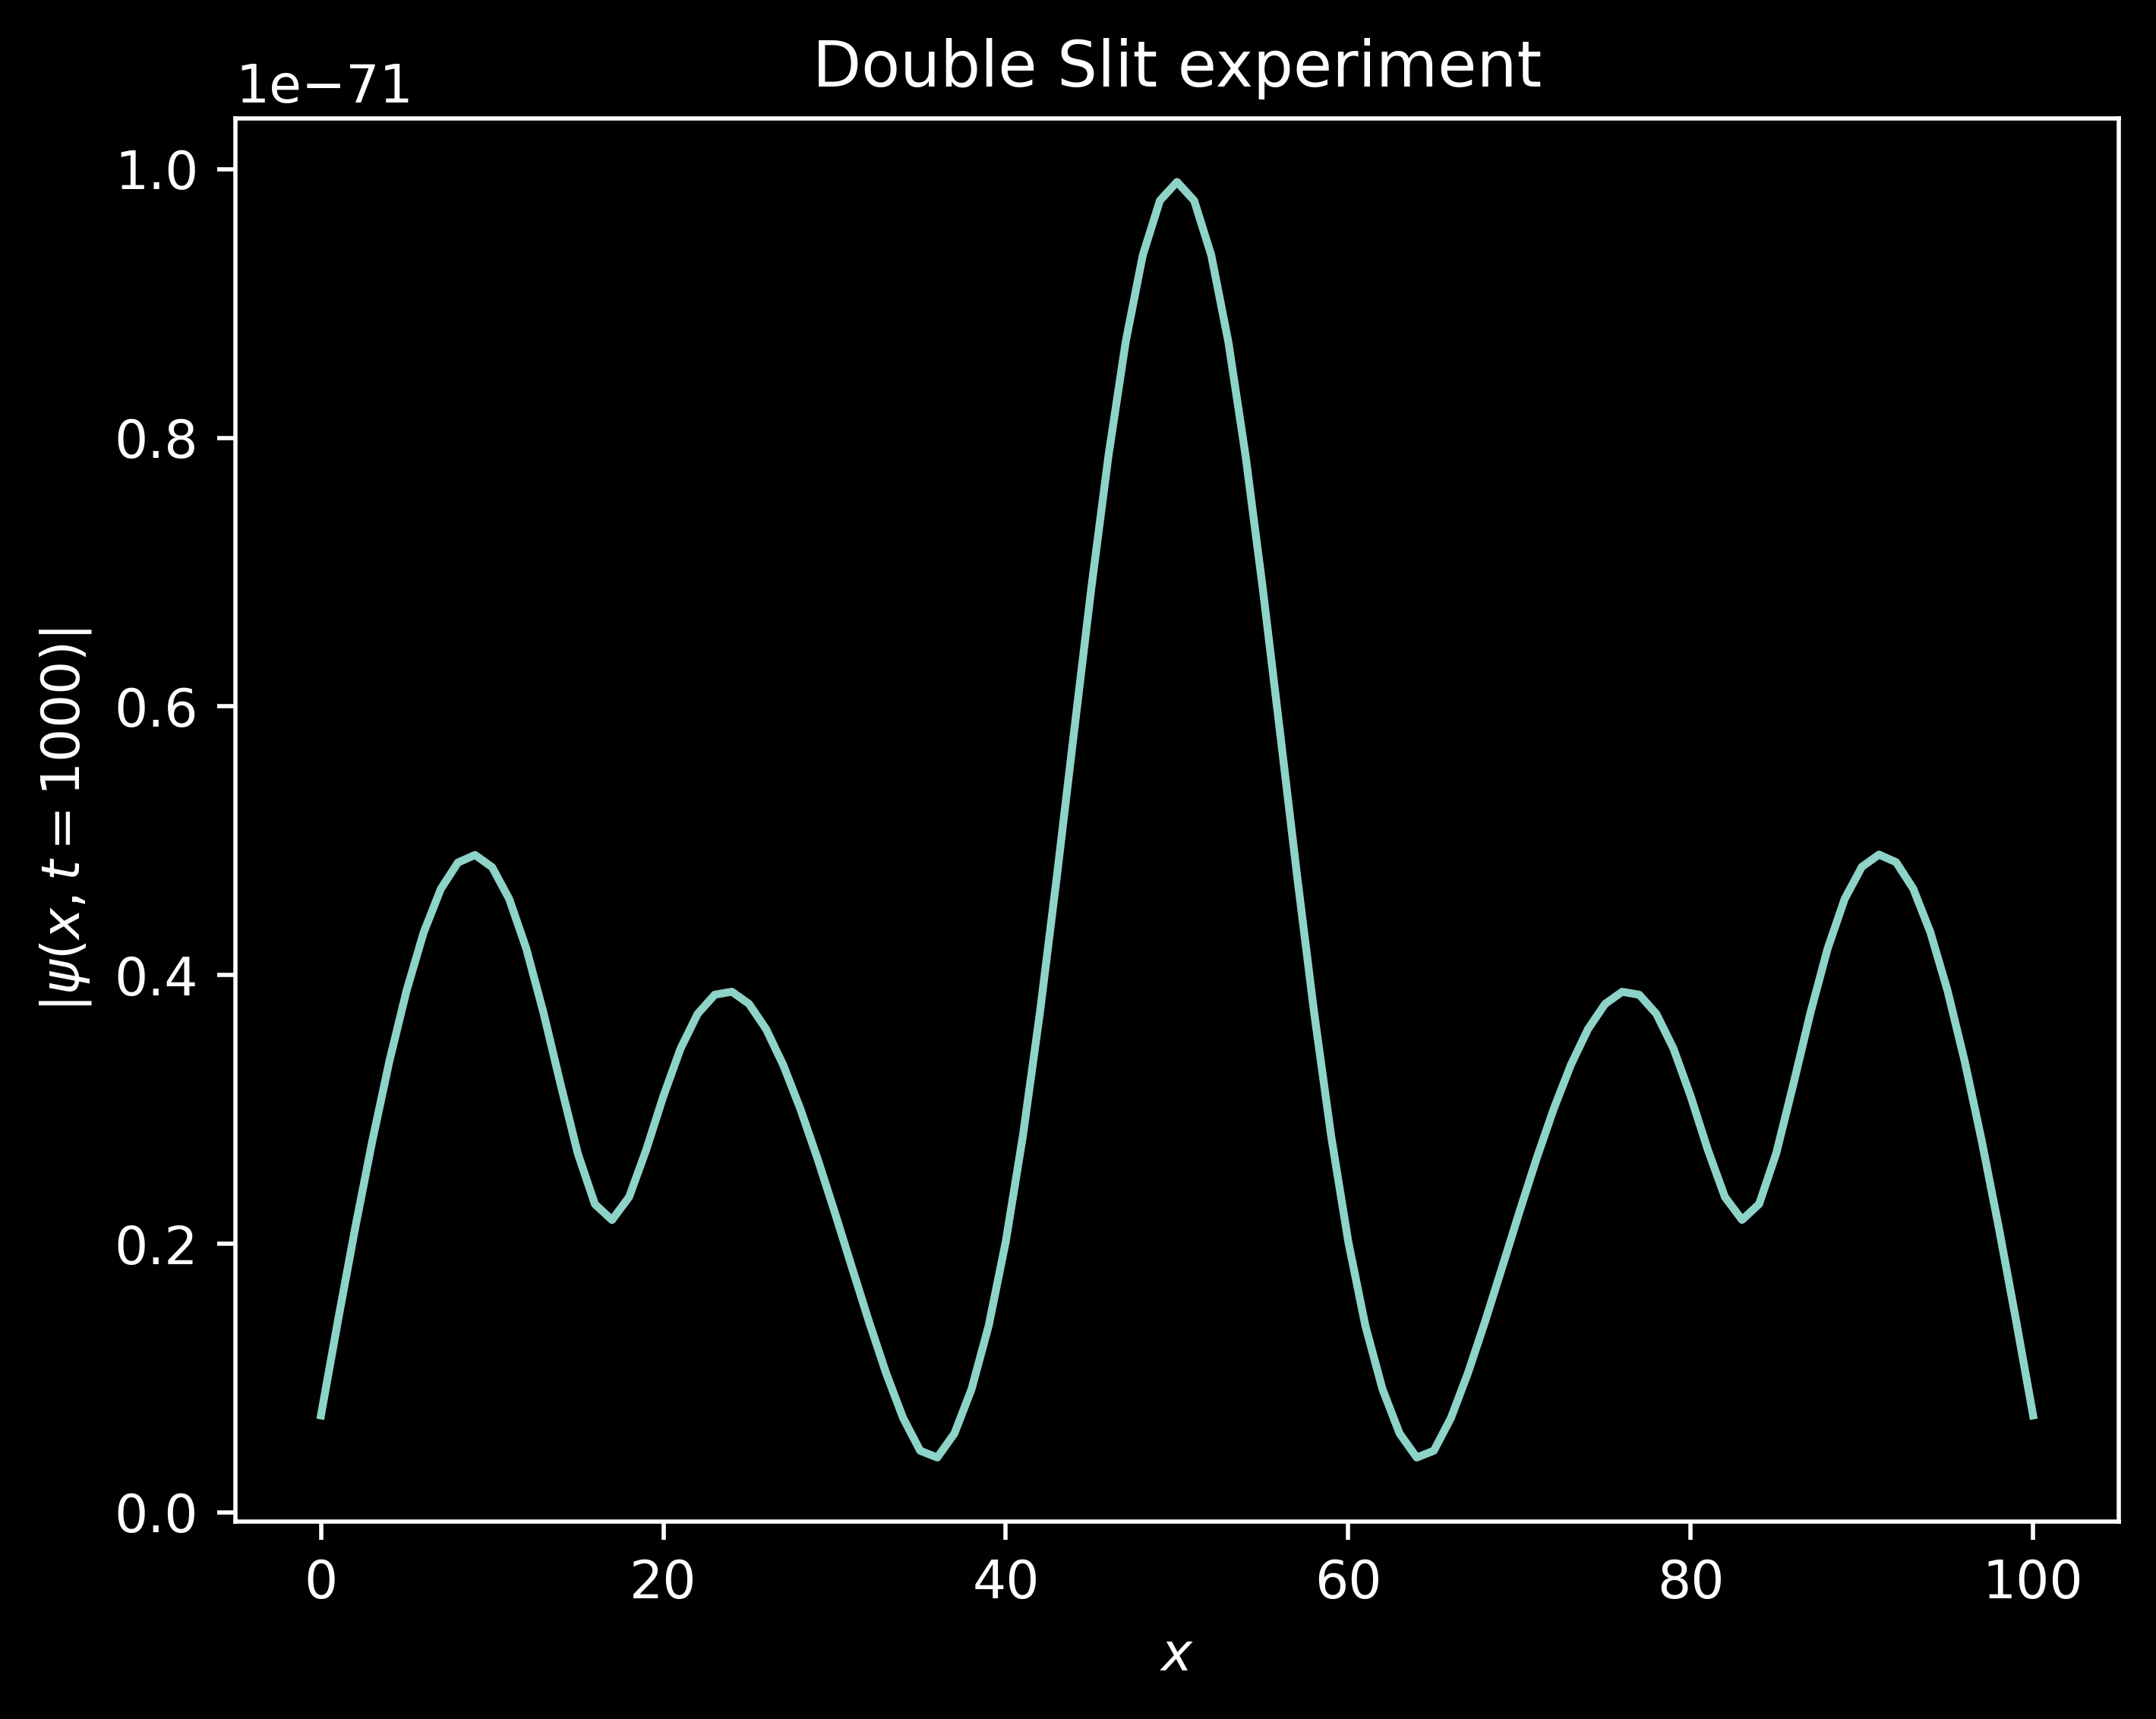

In [12]:
plt.figure(dpi = 500)
plt.xlabel("$x$")
plt.ylabel("$|\psi(x, t = " + str(1000) + ")|$")
plt.title("Double Slit experiment")
plt.plot(np.absolute(Psi(1000))[:, -1])
plt.savefig('Double_slit_experiment_absolutevalue_wider.png')
plt.show()

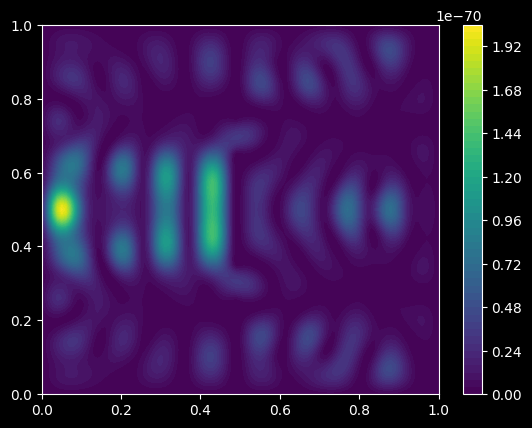

In [17]:
import matplotlib.animation as animation

# Generating the data for the plot
# X = np.linspace(-np.pi, np.pi, 256)
# Y = np.linspace(-np.pi, np.pi, 256)
# X, Y = np.meshgrid(X, Y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# Creating the plot
fig, ax = plt.subplots()
c = ax.contourf(X, Y, np.absolute(Psi(0)), levels = 50)
cbar = plt.colorbar(c)

# Defining the animation function
def animate(i):
    Z = np.absolute(np.absolute(Psi(15*i))**2)
    c = ax.contourf(X, Y, Z, levels = 50)
    # ax.set_title('%03d'%(i*25))
    return c

# Creating the animation
ani = animation.FuncAnimation(fig, animate, frames=300)
ani.save("Doubleslittest.gif",writer='pillow',fps=30,dpi=100)
# Display the animation
plt.show()